In [47]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
# # load eviction data
# from google.colab import files
# uploaded = files.upload()

# uploaded manually

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
file_path = '/content/drive/My Drive/X999/complaints_2024.csv'

In [49]:
# cleaning functions
def drop_columns(df, columns):
    df.drop(columns, axis=1, inplace=True)

def clean_column_names(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.strip().str.replace(' ', '_')
    return df

In [50]:
complaints_df = pd.read_csv(file_path)

In [51]:
complaints_df.head(2)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,59887043,01/01/2024 12:00:20 AM,01/01/2024 12:41:01 AM,NYPD,New York City Police Department,Illegal Fireworks,NaN,Street/Sidewalk,11228.0,7223 FORT HAMILTON PARKWAY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.627094,-74.014497,"(40.62709413549678, -74.01449651007135)"
1,59889016,01/01/2024 12:00:20 AM,01/01/2024 12:59:31 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10468.0,233 LANDING ROAD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.862406,-73.911097,"(40.86240645467484, -73.91109714827905)"


In [ ]:
# complaints_df.columns

In [ ]:
# complaints_df = drop_unneccessary_columns(complaints_df)

In [52]:
complaints_df = clean_column_names(complaints_df)

In [53]:
complaints_df.shape, \
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416000 entries, 0 to 2415999
Data columns (total 41 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   unique_key                      int64  
 1   created_date                    object 
 2   closed_date                     object 
 3   agency                          object 
 4   agency_name                     object 
 5   complaint_type                  object 
 6   descriptor                      object 
 7   location_type                   object 
 8   incident_zip                    float64
 9   incident_address                object 
 10  street_name                     object 
 11  cross_street_1                  object 
 12  cross_street_2                  object 
 13  intersection_street_1           object 
 14  intersection_street_2           object 
 15  address_type                    object 
 16  city                            object 
 17  landmark                   

((2416000, 41), None)

In [54]:
complaints_df.tail(2)

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
2415998,62479086,09/18/2024 01:51:13 AM,NaN,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Street/Sidewalk,11421.0,80-20 PARK LN SOUTH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.695852,-73.862826,"(40.69585236180941, -73.86282625639046)"
2415999,62474979,09/18/2024 02:24:09 AM,NaN,DOT,Department of Transportation,Street Condition,Pothole,NaN,11377.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.738349,-73.902736,"(40.73834898515926, -73.90273572345542)"


In [56]:
complaints_df.created_date =  pd.to_datetime(complaints_df.created_date)
complaints_df.closed_date =  pd.to_datetime(complaints_df.closed_date)

In [57]:
complaints_df.created_date.min(), complaints_df.created_date.max(), \
complaints_df.closed_date.min(), complaints_df.closed_date.max()

# amazing

(Timestamp('2024-01-01 00:00:20'),
 Timestamp('2024-09-18 02:24:09'),
 Timestamp('2023-02-22 10:15:00'),
 Timestamp('2024-09-30 14:20:00'))

In [58]:
complaints_df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'facility_type', 'status', 'due_date',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'bbl', 'borough', 'x_coordinate_(state_plane)',
       'y_coordinate_(state_plane)', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'vehicle_type',
       'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment',
       'latitude', 'longitude', 'location'],
      dtype='object')

In [65]:
# complaints_df.park_borough.unique()

AttributeError: 'DataFrame' object has no attribute 'park_borough'

In [90]:
def drop_empty_columns(df):
    # Drop columns that are completely or almost empty
    na_col_count = df.isna().sum()  # Get the count of NaNs in each column
    columns_to_drop = []

    for column, na_count in na_col_count.items():  # Use .items() instead of .iteritems()
        if na_count / len(df) >= 0.85:  # Check if the column has 85% or more NaNs
            columns_to_drop.append(column)

    df.drop(columns_to_drop, axis=1, inplace=False)  # Drop the columns
    return df

def drop_unneccessary_columns(df):
    #drop the unneccesary columns
    cols = ['x_coordinate_(state_plane)',"agency_name", "agency",
       'y_coordinate_(state_plane)', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'vehicle_type',
       'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment']
    df.drop(cols,axis=1,inplace=False)
    return df

In [87]:
# complaints_df_cleaned = drop_unneccessary_columns(complaints_df)

In [91]:
complaints_df_cleaned = drop_empty_columns(complaints_df)

In [92]:
complaints_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416000 entries, 0 to 2415999
Data columns (total 27 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   unique_key                      int64         
 1   created_date                    datetime64[ns]
 2   closed_date                     datetime64[ns]
 3   complaint_type                  object        
 4   descriptor                      object        
 5   location_type                   object        
 6   incident_zip                    float64       
 7   incident_address                object        
 8   street_name                     object        
 9   cross_street_1                  object        
 10  cross_street_2                  object        
 11  intersection_street_1           object        
 12  intersection_street_2           object        
 13  address_type                    object        
 14  city                            object        
 15

In [93]:
print(complaints_df_cleaned.isnull().sum())

unique_key                              0
created_date                            0
closed_date                        146029
complaint_type                          0
descriptor                          80546
location_type                      294112
incident_zip                        24596
incident_address                    87964
street_name                         88054
cross_street_1                     661496
cross_street_2                     661393
intersection_street_1              757430
intersection_street_2              756371
address_type                         9892
city                               120165
landmark                           934932
facility_type                     2405561
status                                  0
due_date                          2402413
resolution_description             109196
resolution_action_updated_date      72200
community_board                         0
bbl                                280345
borough                           

In [94]:
# drop rows that have NaN in geo data columns
complaints_df_cleaned = complaints_df_cleaned.dropna(subset=['latitude', 'longitude'])

In [95]:
complaints_df_cleaned.shape, \
complaints_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2373459 entries, 0 to 2415999
Data columns (total 27 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   unique_key                      int64         
 1   created_date                    datetime64[ns]
 2   closed_date                     datetime64[ns]
 3   complaint_type                  object        
 4   descriptor                      object        
 5   location_type                   object        
 6   incident_zip                    float64       
 7   incident_address                object        
 8   street_name                     object        
 9   cross_street_1                  object        
 10  cross_street_2                  object        
 11  intersection_street_1           object        
 12  intersection_street_2           object        
 13  address_type                    object        
 14  city                            object        
 15  lan

((2373459, 27), None)

In [96]:
complaints_df_cleaned.head(1)

,unique_key,created_date,closed_date,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,...,status,due_date,resolution_description,resolution_action_updated_date,community_board,bbl,borough,latitude,longitude,location
0,59887043,2024-01-01 00:00:20,2024-01-01 00:41:01,Illegal Fireworks,NaN,Street/Sidewalk,11228.0,7223 FORT HAMILTON PARKWAY,FORT HAMILTON PARKWAY,72 STREET,...,Closed,NaN,The Police Department responded to the complai...,01/01/2024 12:41:04 AM,10 BROOKLYN,3.059130e+09,BROOKLYN,40.627094,-74.014497,"(40.62709413549678, -74.01449651007135)"


['Illegal Fireworks' 'Noise - Residential' 'Noise - Street/Sidewalk'
 'PAINT/PLASTER' 'WATER LEAK' 'Blocked Driveway' 'HEAT/HOT WATER'
 'Noise - Commercial' 'Animal-Abuse' 'Illegal Parking'
 'Special Projects Inspection Team (SPIT)' 'Non-Emergency Police Matter'
 'Indoor Air Quality' 'Lead' 'Encampment' 'Taxi Complaint' 'Noise'
 'Panhandling' 'UNSANITARY CONDITION' 'PLUMBING' 'ELECTRIC'
 'Abandoned Vehicle' 'Noise - Vehicle' 'APPLIANCE' 'GENERAL'
 'Noise - Helicopter' 'Rodent' 'Drug Activity' 'Dead Animal'
 'Noise - House of Worship' 'Sewer' 'Dirty Condition' 'Noise - Park'
 'Drinking' 'Water System' 'General Construction/Plumbing' 'Lost Property'
 'Traffic' 'Obstruction' 'Elevator' 'Air Quality' 'Curb Condition'
 'Missed Collection' 'Street Light Condition' 'Sidewalk Condition'
 'SAFETY' 'DOOR/WINDOW' 'FLOORING/STAIRS' 'Smoking'
 'Traffic Signal Condition' 'Emergency Response Team (ERT)' 'Building/Use'
 'Asbestos' 'Public Toilet' 'Derelict Vehicles' 'Outdoor Dining'
 'For Hire Vehicle

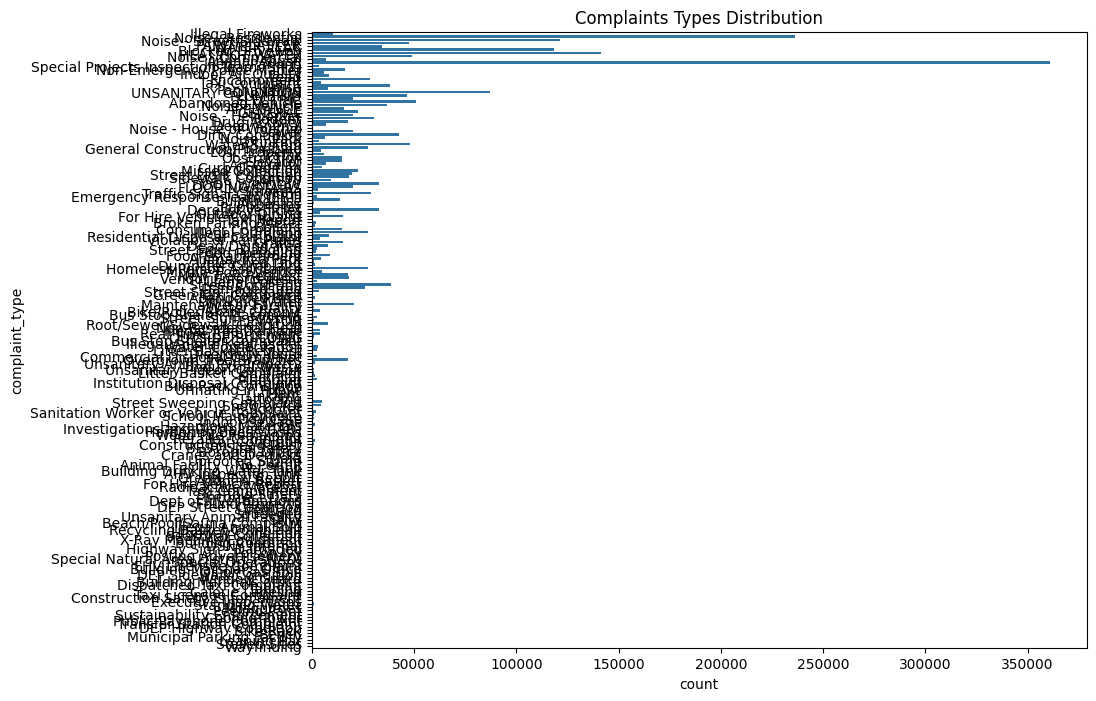

In [97]:
print(complaints_df_cleaned.complaint_type.unique())
plt.figure(figsize=(10,8))
plt.title('Complaints Types Distribution')
sns.countplot(y='complaint_type', data=complaints_df_cleaned)
plt.show()

In [ ]:
# complaints_df.isna().sum().where(lambda x:x>0).dropna()

In [ ]:
# oausou

In [104]:
# cleaning idea: https://www.kaggle.com/code/riyapatel1697/nyc-b311-customer-service-requests-analysis
#dropping rows where closed and resolution date both are empty
complaints_df_clean2 = complaints_df_cleaned[~(complaints_df_cleaned['closed_date'].isna() & complaints_df_cleaned['resolution_action_updated_date'].isna())]
#updating closed date with resolution date where closed date is empty and vice versa
complaints_df_clean2.loc[complaints_df_clean2['closed_date'].isna(),'closed_date'] = complaints_df_clean2[complaints_df_clean2['closed_date'].isna()]['resolution_action_updated_date']
complaints_df_clean2.loc[complaints_df_clean2['resolution_action_updated_date'].isna(),'resolution_action_updated_date'] = complaints_df_clean2[complaints_df_clean2['resolution_action_updated_date'].isna()]['closed_date']

In [106]:
complaints_df_clean2.loc[complaints_df_clean2.status.isin(['open','assigned','draft']),'status'] = 'closed'

In [109]:
city = complaints_df_clean2.city.mode()[0]
zipcode = complaints_df_clean2.loc[complaints_df_clean2.city == city,'incident_zip'].mode()[0]
latitude = complaints_df_clean2.loc[complaints_df_clean2['incident_zip'] == zipcode,'latitude'].mode()[0]
longitude = complaints_df_clean2.loc[complaints_df_clean2['incident_zip'] == zipcode,'longitude'].mode()[0]
#fill zipcode,latitude and longitude with modevalues where city is empty and then update city value to mode value
complaints_df_clean2.loc[complaints_df_clean2.city.isna(),'incident_zip'] = zipcode
complaints_df_clean2.loc[complaints_df_clean2.city.isna(),'city'] = city
complaints_df_clean2.loc[(complaints_df_clean2.city == city) & (complaints_df_clean2.latitude.isna()==True),'latitude'] = latitude
complaints_df_clean2.loc[(complaints_df_clean2.city == city) & (complaints_df_clean2.longitude.isna()==True),'longitude'] = longitude

In [117]:
complaints_df_clean2.head()

,unique_key,created_date,closed_date,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,...,status,due_date,resolution_description,resolution_action_updated_date,community_board,bbl,borough,latitude,longitude,location
0,59887043,2024-01-01 00:00:20,2024-01-01 00:41:01,Illegal Fireworks,NaN,Street/Sidewalk,11228.0,7223 FORT HAMILTON PARKWAY,FORT HAMILTON PARKWAY,72 STREET,...,Closed,NaN,The Police Department responded to the complai...,01/01/2024 12:41:04 AM,10 BROOKLYN,3.059130e+09,BROOKLYN,40.627094,-74.014497,"(40.62709413549678, -74.01449651007135)"
1,59889016,2024-01-01 00:00:20,2024-01-01 00:59:31,Noise - Residential,Loud Music/Party,Residential Building/House,10468.0,233 LANDING ROAD,LANDING ROAD,CEDAR AVENUE,...,Closed,NaN,The Police Department responded to the complai...,01/01/2024 12:59:34 AM,07 BRONX,2.032368e+09,BRONX,40.862406,-73.911097,"(40.86240645467484, -73.91109714827905)"
2,59888940,2024-01-01 00:00:43,2024-01-01 00:56:45,Noise - Residential,Banging/Pounding,Residential Building/House,11207.0,640 STANLEY AVENUE,STANLEY AVENUE,VERMONT STREET,...,Closed,NaN,The Police Department responded to the complai...,01/01/2024 12:56:50 AM,05 BROOKLYN,3.043710e+09,BROOKLYN,40.658932,-73.884863,"(40.65893182677183, -73.88486278314905)"
3,59891528,2024-01-01 00:00:46,2024-01-01 01:07:17,Illegal Fireworks,NaN,Residential Building/House,11417.0,106-23 75 STREET,75 STREET,GLENMORE AVENUE,...,Closed,NaN,The Police Department responded to the complai...,01/01/2024 01:07:21 AM,10 QUEENS,4.091250e+09,QUEENS,40.677497,-73.861919,"(40.67749697136948, -73.86191943842041)"
4,59892651,2024-01-01 00:00:48,2024-01-01 00:48:34,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,11377.0,41-52 72 STREET,72 STREET,41 AVENUE,...,Closed,NaN,The Police Department responded to the complai...,01/01/2024 12:48:39 AM,02 QUEENS,4.013110e+09,QUEENS,40.743761,-73.893186,"(40.74376141146886, -73.8931860929054)"


In [111]:
# complaints_df_clean2.isna().sum().where(lambda x:x>0).dropna()

,0
descriptor,79095.0
location_type,265789.0
incident_zip,85.0
incident_address,75940.0
street_name,75986.0
cross_street_1,647846.0
cross_street_2,647202.0
intersection_street_1,728508.0
intersection_street_2,727547.0
address_type,4465.0


In [121]:
complaints_df_clean2.loc[:,'request_closing_time_in_hours'] = (complaints_df_clean2['closed_date'] - complaints_df_clean2['created_date']).dt.total_seconds()

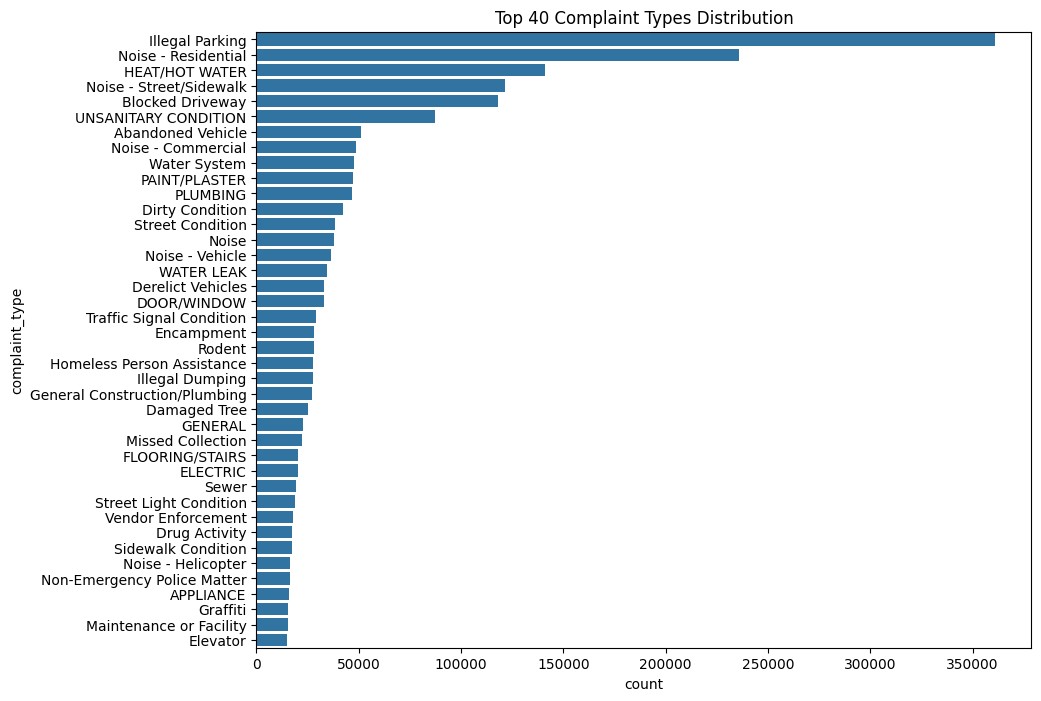

In [126]:
top_40_complaints = complaints_df_clean2['complaint_type'].value_counts().nlargest(40).index
df_top_40 = complaints_df_clean2[complaints_df_clean2['complaint_type'].isin(top_40_complaints)]

# plot the data
plt.figure(figsize=(10,8))
plt.title('Top 40 Complaint Types Distribution')
sns.countplot(y='complaint_type', data=df_top_40, order=top_40_complaints)
plt.show()


['Illegal Fireworks' 'Noise - Residential' 'Noise - Street/Sidewalk'
 'PAINT/PLASTER' 'WATER LEAK' 'Blocked Driveway' 'HEAT/HOT WATER'
 'Noise - Commercial' 'Animal-Abuse' 'Illegal Parking'
 'Special Projects Inspection Team (SPIT)' 'Non-Emergency Police Matter'
 'Lead' 'Encampment' 'Taxi Complaint' 'Noise' 'Panhandling'
 'UNSANITARY CONDITION' 'PLUMBING' 'ELECTRIC' 'Abandoned Vehicle'
 'Noise - Vehicle' 'APPLIANCE' 'GENERAL' 'Noise - Helicopter' 'Rodent'
 'Drug Activity' 'Dead Animal' 'Noise - House of Worship' 'Sewer'
 'Dirty Condition' 'Noise - Park' 'Drinking' 'Water System'
 'General Construction/Plumbing' 'Lost Property' 'Traffic' 'Obstruction'
 'Elevator' 'Air Quality' 'Curb Condition' 'Missed Collection'
 'Street Light Condition' 'Sidewalk Condition' 'SAFETY' 'DOOR/WINDOW'
 'FLOORING/STAIRS' 'Smoking' 'Traffic Signal Condition'
 'Emergency Response Team (ERT)' 'Building/Use' 'Public Toilet'
 'Derelict Vehicles' 'Indoor Air Quality' 'Outdoor Dining'
 'For Hire Vehicle Complaint'

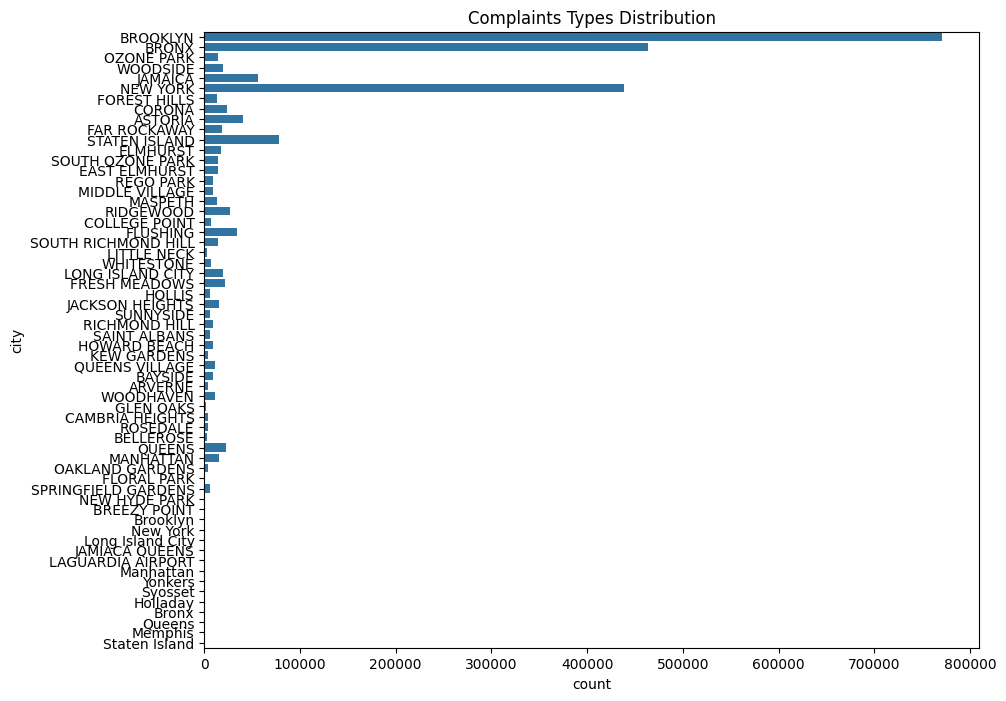

In [122]:
print(complaints_df_clean2.complaint_type.unique())
plt.figure(figsize=(10,8))
plt.title('Complaints Types Distribution')
sns.countplot(y='city', data=complaints_df_clean2)
plt.show()

In [127]:
# complaints_df_cleaned2.shape, \
# complaints_df_cleaned2.info()

In [128]:
# complaints_df_cleaned.isna().sum().where(lambda x:x>0).dropna()

In [129]:
# complaints_df_cleaned.shape, \
# complaints_df_cleaned.info()

In [130]:
# complaints_df_cleaned.dropna(inplace=True)

In [131]:
# complaints_df_cleaned.loc[:,'request_closing_time_in_hours'] = (complaints_df_cleaned['closed_date'] - complaints_df_cleaned['created_date']).dt.total_seconds()

In [132]:
# complaints_df_cleaned.shape, \
# complaints_df_cleaned.info()

In [136]:
len(complaints_df_clean2.complaint_type.unique())

180

In [137]:
# save cleaned 311 complaints data to my drive
complaints_df_clean2.to_csv('/content/drive/My Drive/X999/complaints_df_clean2024.csv', index=False)

In [139]:
complaints_df_clean2.head()

,unique_key,created_date,closed_date,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,...,due_date,resolution_description,resolution_action_updated_date,community_board,bbl,borough,latitude,longitude,location,request_closing_time_in_hours
0,59887043,2024-01-01 00:00:20,2024-01-01 00:41:01,Illegal Fireworks,NaN,Street/Sidewalk,11228.0,7223 FORT HAMILTON PARKWAY,FORT HAMILTON PARKWAY,72 STREET,...,NaN,The Police Department responded to the complai...,01/01/2024 12:41:04 AM,10 BROOKLYN,3.059130e+09,BROOKLYN,40.627094,-74.014497,"(40.62709413549678, -74.01449651007135)",2441.0
1,59889016,2024-01-01 00:00:20,2024-01-01 00:59:31,Noise - Residential,Loud Music/Party,Residential Building/House,10468.0,233 LANDING ROAD,LANDING ROAD,CEDAR AVENUE,...,NaN,The Police Department responded to the complai...,01/01/2024 12:59:34 AM,07 BRONX,2.032368e+09,BRONX,40.862406,-73.911097,"(40.86240645467484, -73.91109714827905)",3551.0
2,59888940,2024-01-01 00:00:43,2024-01-01 00:56:45,Noise - Residential,Banging/Pounding,Residential Building/House,11207.0,640 STANLEY AVENUE,STANLEY AVENUE,VERMONT STREET,...,NaN,The Police Department responded to the complai...,01/01/2024 12:56:50 AM,05 BROOKLYN,3.043710e+09,BROOKLYN,40.658932,-73.884863,"(40.65893182677183, -73.88486278314905)",3362.0
3,59891528,2024-01-01 00:00:46,2024-01-01 01:07:17,Illegal Fireworks,NaN,Residential Building/House,11417.0,106-23 75 STREET,75 STREET,GLENMORE AVENUE,...,NaN,The Police Department responded to the complai...,01/01/2024 01:07:21 AM,10 QUEENS,4.091250e+09,QUEENS,40.677497,-73.861919,"(40.67749697136948, -73.86191943842041)",3991.0
4,59892651,2024-01-01 00:00:48,2024-01-01 00:48:34,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,11377.0,41-52 72 STREET,72 STREET,41 AVENUE,...,NaN,The Police Department responded to the complai...,01/01/2024 12:48:39 AM,02 QUEENS,4.013110e+09,QUEENS,40.743761,-73.893186,"(40.74376141146886, -73.8931860929054)",2866.0
